In [205]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Generate State Space

The state space is 2-dimensional, consisting of `num_concepts` different classes. Class $c_i$ is generated by sampling from a normal distribution $~\mathcal{N}(\mu_{c_i}, \sigma_{c_i})$. The concept of a class is assumed to be its mean $\mu_{c_i}$.

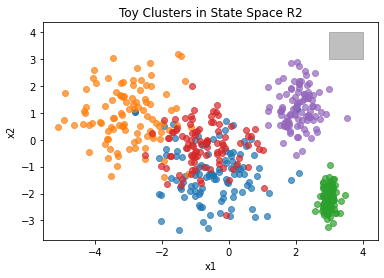

In [233]:
num_concepts = 5
examples_per_concept = 100

# Sample candidate class means from uniform distribution
x1 = np.random.uniform(-3, 3, num_concepts)
x2 = np.random.uniform(-3, 3, num_concepts)
means = np.stack((x1, x2), axis=1)

fig, ax = plt.subplots()
plt.scatter(x1, x2)

clusters = np.zeros((examples_per_concept*num_concepts, 2))
y = np.zeros(examples_per_concept*num_concepts)

for i in range(num_concepts):
    y[i*examples_per_concept: (i+1)*examples_per_concept] = i
    cov = [[np.random.uniform(0.01, 1), 0], [0, np.random.uniform(0.01, 1)]]
    x1, x2 = np.random.multivariate_normal(
        means[i], cov, size=examples_per_concept, check_valid='warn').T
    plt.plot(x1, x2, 'o', alpha=0.7)

rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax.add_patch(rect)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Toy Clusters in State Space R2")
plt.show()


### Environment Dynamics

Suppose the goal of the agent is to reach the upper right corner our confined state space, a square located at (3,3). Let the reward of of all steps in which the goal is not achieved by -1. Additionally, suppose there is a $\textit{wind}$ acting in the negative $x$ direction, pushing the agent further from its goal. Suppose also that the agent experiences the wind more severely in certain regions of the state space; characterised by the concept classes in the dataset.

Let the action space comprise of 4 discrete actions: {up, down, right, left}

The transtition to the next state $T(s'|s)$ is given as
$ s_{t+1} = s_{t} + \Delta_{ss} \cdot a_t + w(s_t) $,
Where $\Delta_{ss}$ is a step size, $a_t$ is a unit vector representing the action and $w(s_t)$ is a function which describes the $\textit{wind severity experienced by the agent}$ given the current state.


### Generate Trajectories